# Exploring Performance of Kalman filters on 3-d trajectory data with sharp maneuvers

## Code adapted from: https://github.com/balzer82/Kalman

|Equation Description | Equation|
|---|---|
|Next state | $x_{k+1} = Ax_k + Bu_k$|
|Next error covariance | $P_{k+1} = AP_kA^T + Q$|
|Kalman Gain | $K_K = P_KH^T(HP_K H^T + R)^{-1}$|
|Estimate update | $x_k = x_k + K_k(z_k - Hx_k)$|
|Error covariance update | $P_k = (I - K_kH)P_k$|


In [130]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from tqdm import tqdm
import math

In [60]:
dt = 0.1
P = 100.0*np.eye(9)
A = np.matrix([
    [1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
])
H = np.matrix([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
])
R = np.matrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0]
])
sj = 0.1
Q = np.matrix([[
    (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0, 0],
    [0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0],
    [0, 0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6],
    [(dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
    [0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0],
    [0, 0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
    [(dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0, 0],
    [0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0],
    [0, 0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2)]
]) *sj**2

B = np.matrix([[0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0]])
u = 0.0
I = np.eye(9)
x = np.matrix([0.0, 0.0, 1.0, 10.0, 0.0, 0.0, 0.0, 0.0, -9.81]).T

In [116]:
frequency = int(100) # Frequency of Vision System
dt = 1.0/frequency
T = 100 # s measuremnt time
m = int(T/dt) # number of measurements

x = 0.0 # x Position Start
y = 0.0 # y Position Start
z = 100.0 # z Position Start

vx = 150.0 # m/s Velocity at the beginning
vy = 0.0 # m/s Velocity
vz = 0.0 # m/s Velocity

c = 0.5 # Drag Resistance Coefficient
g = -9.806

Xr = []
Yr = []
Zr = []

generator_axt = [t*8/frequency for t in range(frequency*5)] + [0 for t in range(frequency*5)] + [np.sin(t/(math.pi/(frequency*5)))*100000 for t in range(frequency*5)]\
                + [0 for t in range(frequency*15)] + [-np.cos(t/(math.pi/(frequency*5)))*50000 for t in range(frequency*5)] + [-np.cos(t/(math.pi/(frequency*10)))*10000 for t in range(frequency*10)]\
                    + [0 for t in range(frequency*10)]

generator_ayt = [0 for t in range(frequency*5)] + [0 for t in range(frequency*5)] + [-np.cos(t/(math.pi/(frequency*5)))*100000 for t in range(frequency*5)]\
                + [0 for t in range(frequency*15)] + [np.sin(t/(math.pi/(frequency*5)))*50000 for t in range(frequency*5)] + [np.sin(t/(math.pi/(frequency*10)))*10000 for t in range(frequency*10)]\
                    + [0 for t in range(frequency*10)]

generator_azt = [t*18/frequency for t in range(frequency*5)]  + [t*15/frequency for t in range(frequency*5)] + [0 for t in range(frequency*5)]\
                + [t*10/frequency for t in range(frequency*5)] + [t*10/frequency for t in range(frequency*5)] + [15 for t in range(frequency*5)]\
                    + [0 for t in range(frequency*10)]

generator_at = list(zip(generator_axt*10, generator_ayt*10, generator_azt*10))

for i in tqdm(range(int(m))):
    
    intent_axt, intent_ayt, intent_azt = 0, 0, 0
    if i < len(generator_at):
        intent_axt, intent_ayt, intent_azt = generator_at[i]
    
    accx = intent_axt -c*vx # Drag Resistance
    vx += accx*dt
    x += vx*dt

    accy = intent_ayt - c*vy
    vy += accy*dt
    y += vy*dt
    
    accz = intent_azt - c*vz + g # Gravitation + Drag
    vz += accz*dt
    z += vz*dt
        
    Xr.append(x)
    Yr.append(y)
    Zr.append(z)

100%|██████████| 10000/10000 [00:00<00:00, 271769.74it/s]


In [117]:
sp= 25 # Sigma for position noise

Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

(243.4006260050984, 2108.5024524172745)

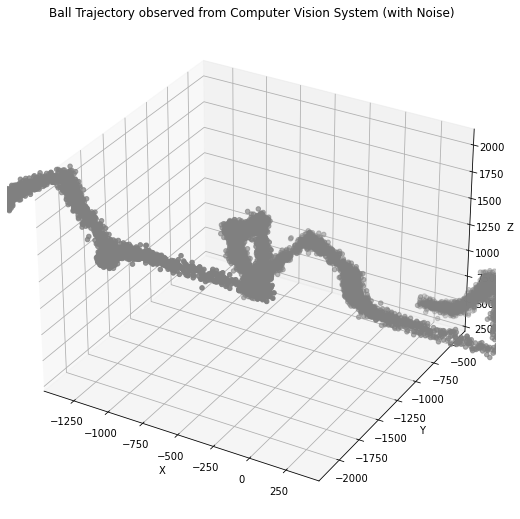

In [118]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm, Ym, Zm, c='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Ball Trajectory observed from Computer Vision System (with Noise)')

#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
#plt.savefig('BallTrajectory-Computervision.png', dpi=150, bbox_inches='tight')

In [119]:
measurements = np.vstack((Xm,Ym,Zm))

In [120]:
x = np.matrix([0.0, 0.0, 100.0, 150.0, 0.0, 0.0, 0.0, 0.0, -9.81]).T
print(x, x.shape)

[[  0.  ]
 [  0.  ]
 [100.  ]
 [150.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [  0.  ]
 [ -9.81]] (9, 1)


In [121]:
# Preallocation for Plotting
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

In [122]:
hitplate=False
for filterstep in range(m):
    
    # Model the direction switch, when hitting the plate
    if x[2]<0.01 and not hitplate:
        x[5]=-x[5]
        hitplate=True
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x + B*u
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,filterstep].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
   
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Pddx.append(float(P[6,6]))
    Pddy.append(float(P[7,7]))
    Pddz.append(float(P[8,8]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))
    Kddx.append(float(K[6,0]))
    Kddy.append(float(K[7,0]))
    Kddz.append(float(K[8,0]))

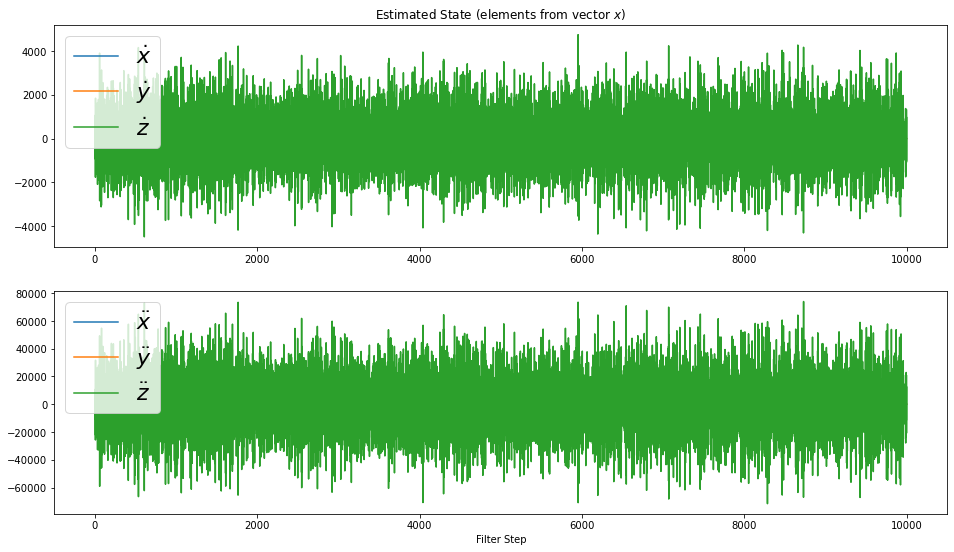

In [123]:
fig = plt.figure(figsize=(16,9))
plt.subplot(211)
plt.title('Estimated State (elements from vector $x$)')
plt.plot(range(len(measurements[0])),dxt, label='$\dot x$')
plt.plot(range(len(measurements[0])),dyt, label='$\dot y$')
plt.plot(range(len(measurements[0])),dzt, label='$\dot z$')
plt.legend(loc='best',prop={'size':22})

plt.subplot(212)
plt.plot(range(len(measurements[0])),ddxt, label='$\ddot x$')
plt.plot(range(len(measurements[0])),ddyt, label='$\ddot y$')
plt.plot(range(len(measurements[0])),ddzt, label='$\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})

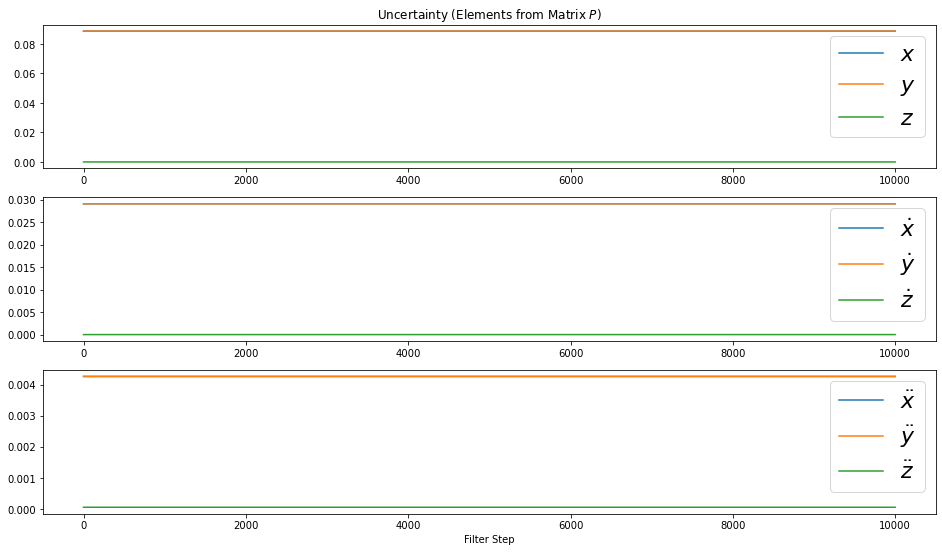

In [124]:
fig = plt.figure(figsize=(16,9))
plt.subplot(311)
plt.plot(range(len(measurements[0])),Px, label='$x$')
plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pz, label='$z$')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})
plt.subplot(312)
plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')
plt.plot(range(len(measurements[0])),Pdz, label='$\dot z$')
plt.legend(loc='best',prop={'size':22})

plt.subplot(313)
plt.plot(range(len(measurements[0])),Pddx, label='$\ddot x$')
plt.plot(range(len(measurements[0])),Pddy, label='$\ddot y$')
plt.plot(range(len(measurements[0])),Pddz, label='$\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})

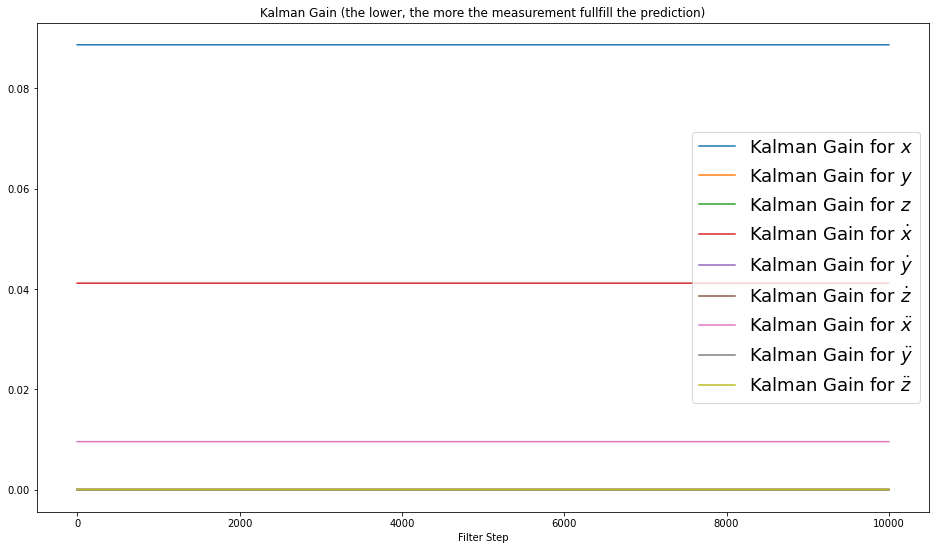

In [125]:
fig = plt.figure(figsize=(16,9))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kz, label='Kalman Gain for $z$')
plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')
plt.plot(range(len(measurements[0])),Kdz, label='Kalman Gain for $\dot z$')
plt.plot(range(len(measurements[0])),Kddx, label='Kalman Gain for $\ddot x$')
plt.plot(range(len(measurements[0])),Kddy, label='Kalman Gain for $\ddot y$')
plt.plot(range(len(measurements[0])),Kddz, label='Kalman Gain for $\ddot z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(loc='best',prop={'size':18})

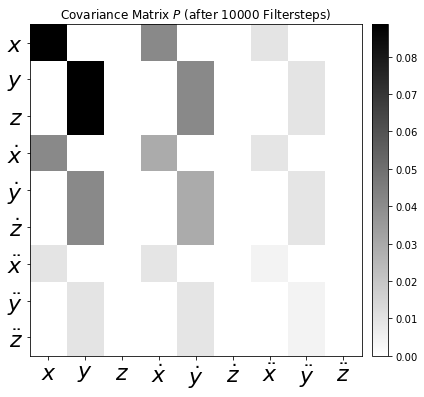

In [126]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filtersteps)' % m)
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(10))
# set the locations and labels of the yticks
plt.yticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(9),('$x$', '$y$', '$z$', '$\dot x$', '$\dot y$', '$\dot z$', '$\ddot x$', '$\ddot y$', '$\ddot z$'), fontsize=22)

plt.xlim([-0.5,8.5])
plt.ylim([8.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

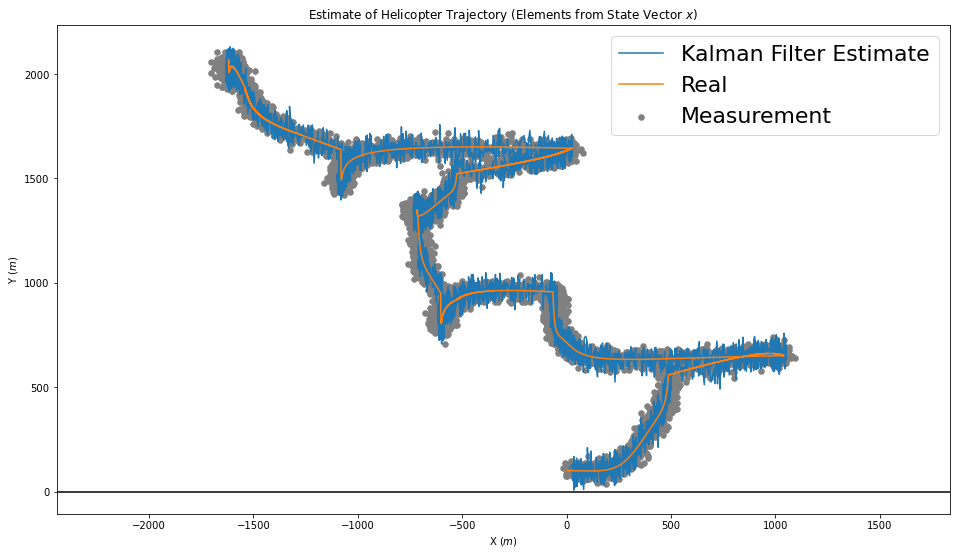

In [129]:
fig = plt.figure(figsize=(16,9))

plt.plot(xt,zt, label='Kalman Filter Estimate')
plt.scatter(Xm,Zm, label='Measurement', c='gray', s=30)
plt.plot(Xr, Zr, label='Real')
plt.title('Estimate of Helicopter Trajectory (Elements from State Vector $x$)')
plt.legend(loc='best',prop={'size':22})
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('X ($m$)')
plt.ylabel('Y ($m$)')
plt.savefig('Kalman-Filter-CA-Ball-StateEstimated.png', dpi=150, bbox_inches='tight')

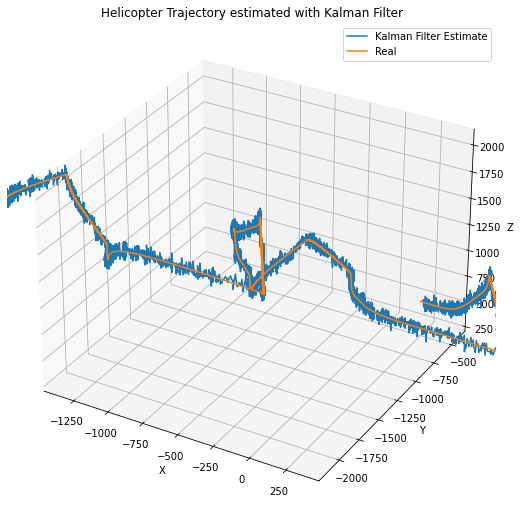

In [128]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate')
ax.plot(Xr, Yr, Zr, label='Real')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Helicopter Trajectory estimated with Kalman Filter')

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.savefig('Kalman-Filter-CA-Ball-Trajectory.png', dpi=150, bbox_inches='tight')